In [412]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import matplotlib.colors as mcolors
from iminuit import Minuit, cost
from iminuit.cost import LeastSquares
hep.style.use("CMS")

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [563]:
input_file_name = 'Data/WScFi10GeV28degreesped.pkl'
sigma_cut = 5

with open(input_file_name, 'rb') as file:
    dataframes_dict = pickle.load(file)
    
data_file_name = 'Data/WScFi10GeV28degreesraw.pkl'

with open(data_file_name, 'rb') as file:
    data_dict = pickle.load(file)
    
out_file_name = 'Data/WScFi10GeV28degrees.pkl'



In [564]:
def least_squares_loss(A, mu, sigma):
    y = gauss(bins, A, mu, sigma)
    return np.sum((data - y)**2)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


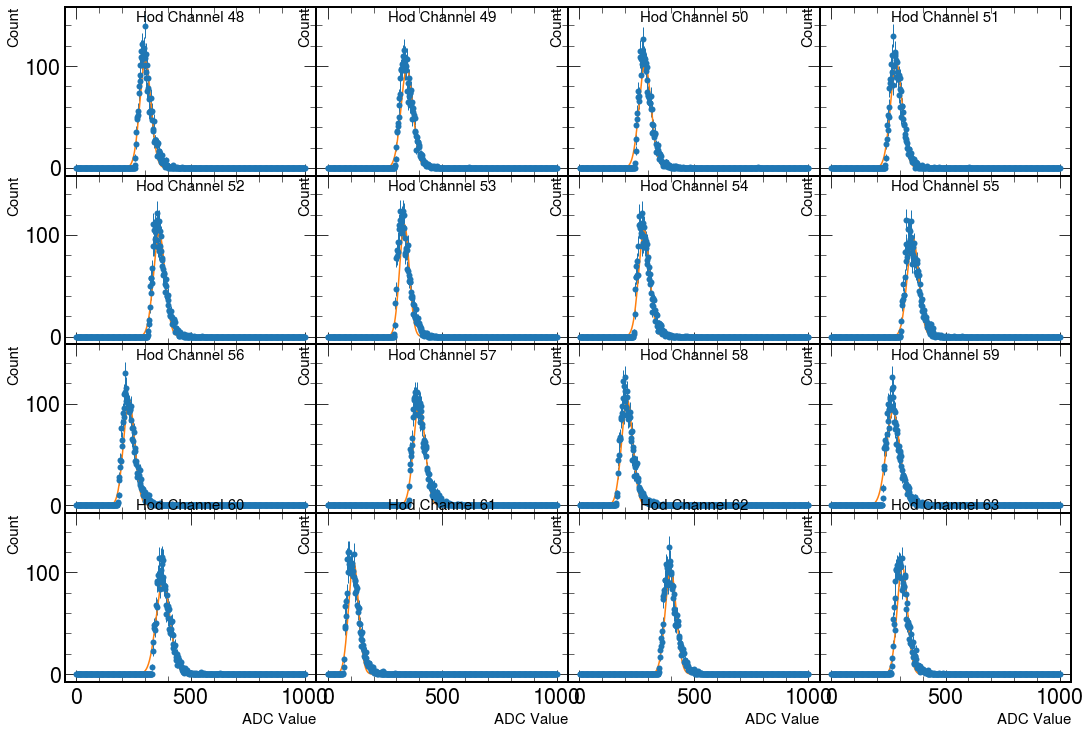

In [565]:
fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharey=True,sharex=True)

# Flatten the axes for easy iteration
axes = axes.flatten()
hod_df = dataframes_dict['hod_df']
Hodped_mean = []
Hodped_std = []

with open("PedestalMeans.txt", "w") as file:
    file.write("Hodoscope")
    file.write('\n')
with open("PedestalSigmas.txt", "w") as file:
    file.write("Hodoscope")
    file.write('\n')

# Iterate over each channel
for i in range(16):
    # Select the ADC values for the channel
    adc_values = hod_df[f'ch_{i + 48}']  # Adjusted to start from ch_48
    
    #HodoscopeCutoff.append(np.mean(adc_values)+cutoffBuffer)
    
    h, bins = np.histogram(adc_values, bins=500, range=(0, 1000))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    errors = np.sqrt(h)
    axes[i].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    mask = (h > 0)
    initial_params = [max(h),np.mean(adc_values), np.std(adc_values)]
    m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']

    x = np.linspace(0, 600, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    
    axes[i].plot(x, y_fit, 'tab:orange')

    
    axes[i].set_title(f'Hod Channel {i + 48}', fontsize = 15, pad=-15)
    axes[i].set_xlabel('ADC Value', fontsize = 15)
    axes[i].set_ylabel('Count', fontsize = 15)
    
    data_dict['hod_df'][f'ch_{i+48}'] = data_dict['hod_df'][f'ch_{i+48}'] - mu_fit
    mask = data_dict['hod_df'][f'ch_{i+48}'] <= sigma_cut*sigma_fit
    data_dict['hod_df'][f'ch_{i+48}'][mask] =0
    
    with open("PedestalMeans.txt", "a") as file:
        file.write(str(mu_fit)+" ")
    with open("PedestalSigmas.txt", "a") as file:
        file.write(str(sigma_fit)+" ")

plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)



/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


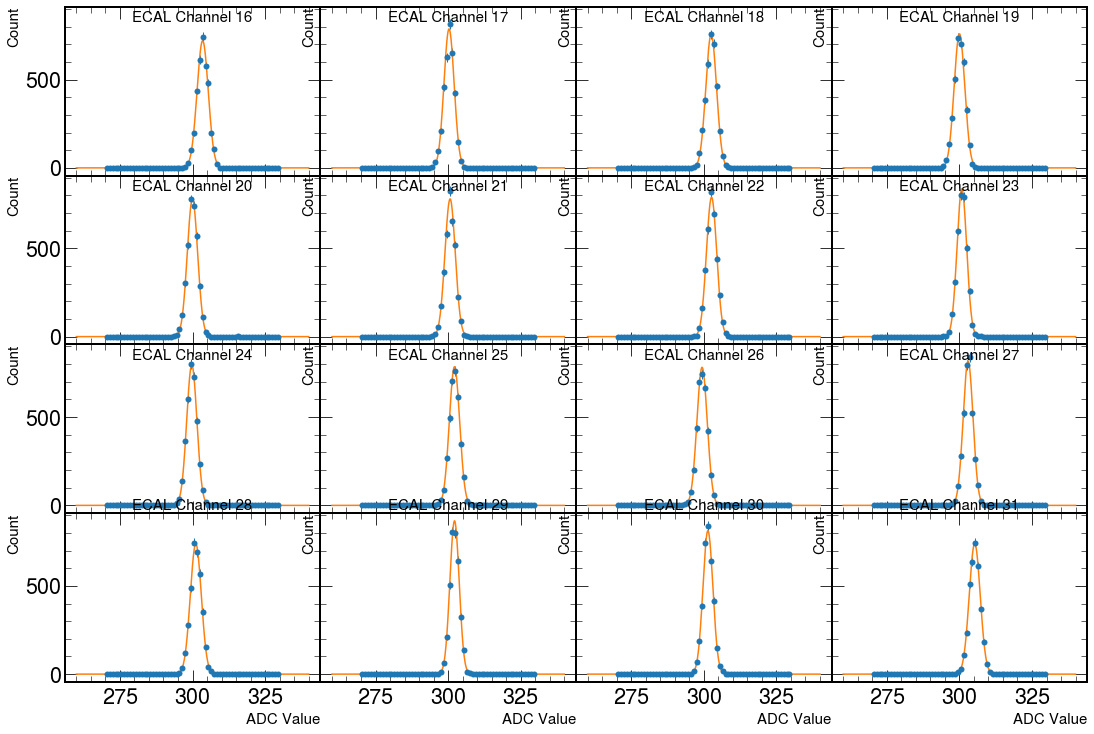

In [566]:
# Plot ADC spectra for each channel in subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

ecal_df = dataframes_dict['ecal_df']

# Flatten the axes for easy iteration
axes = axes.flatten()
with open("PedestalMeans.txt", "a") as file:
    file.write('\n')
    file.write("ECAL")
    file.write('\n')
with open("PedestalSigmas.txt", "a") as file:
    file.write('\n')
    file.write("ECAL")
    file.write('\n')

# Iterate over each channel
for i in range(16):
    # Select the ADC values for the channel
    adc_values = ecal_df[f'ch_{i + 16}']  # Adjusted to start from ch_48
    
    h, bins = np.histogram(adc_values, bins=60, range=(270, 330))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    errors = np.sqrt(h)
    axes[i].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    
    
    mask = (h > 1) & (bin_centers > 260) & (bin_centers < 340)
    initial_params = [max(h),300, 1.1]
    m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, 10)
    m.limits["mu"] = (290, 310)

    m.migrad()
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']

    x = np.linspace(260, 340, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    
    axes[i].plot(x, y_fit, 'tab:orange')
    
    axes[i].set_title(f'ECAL Channel {i + 16}', fontsize = 15, pad=-15)  # Adjusted channel title
    axes[i].set_xlabel('ADC Value', fontsize = 15)
    axes[i].set_ylabel('Count', fontsize = 15)
    
    data_dict['ecal_df'][f'ch_{i+16}'] = data_dict['ecal_df'][f'ch_{i+16}'] - mu_fit
    mask = data_dict['ecal_df'][f'ch_{i+16}'] <= sigma_cut*sigma_fit
    data_dict['ecal_df'][f'ch_{i+16}'][mask] = 0
    
    with open("PedestalMeans.txt", "a") as file:
        file.write(str(mu_fit)+" ")
    with open("PedestalSigmas.txt", "a") as file:
        file.write(str(sigma_fit)+" ")

plt.tight_layout(pad=0.0)
plt.subplots_adjust(hspace=0.0, wspace=0.0)

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


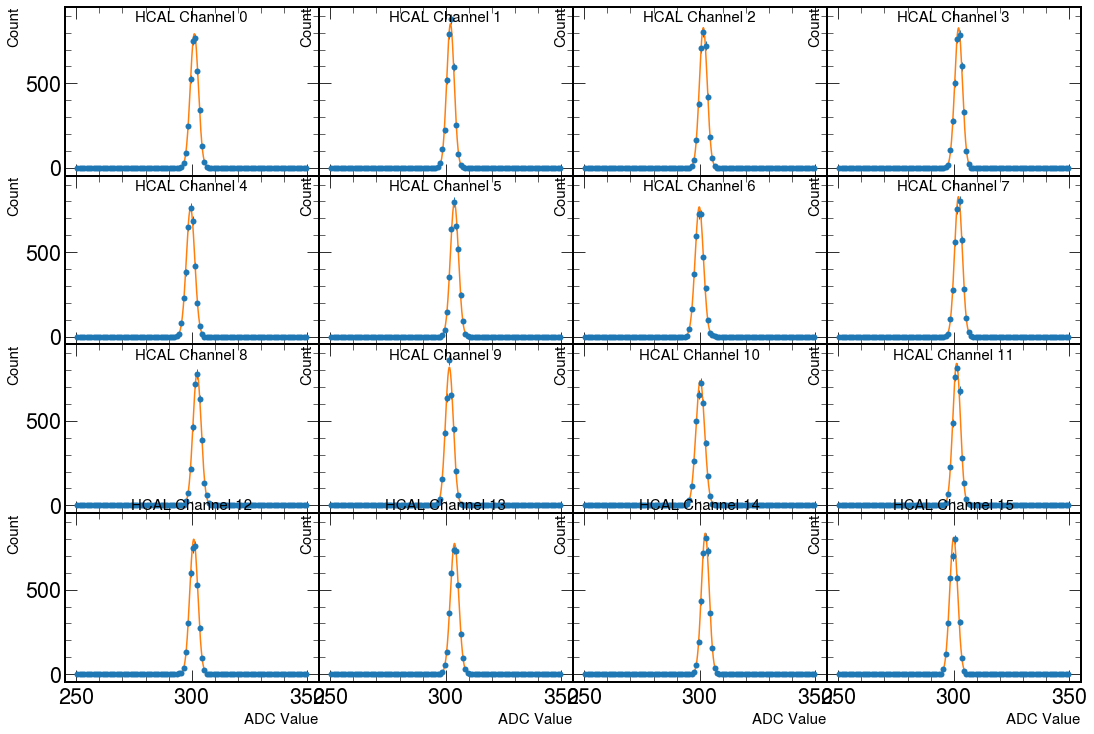

In [567]:
# Plot ADC spectra for each channel in subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 10), sharey=True,sharex=True)
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

hcal_df = dataframes_dict['hcal_df']
with open("PedestalMeans.txt", "a") as file:
    file.write('\n')
    file.write("HCAL")
    file.write('\n')
with open("PedestalSigmas.txt", "a") as file:
    file.write('\n')
    file.write("HCAL")
    file.write('\n')

# Flatten the axes for easy iteration
axes = axes.flatten()
# Iterate over each channel
for i in range(16):
    # Select the ADC values for the channel
    adc_values = hcal_df[f'ch_{i}']  # Adjusted to start from ch_48
  
    h, bins = np.histogram(adc_values, bins=100, range=(250, 350))
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    errors = np.sqrt(h)
    axes[i].errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    
    mask = (h > 0)
    initial_params = [max(h),np.mean(adc_values), np.std(adc_values)]
    m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
    m.limits["sigma"] = (0, None)
    m.migrad()
    fitted_params = m.values
    A_fit = fitted_params['A']
    mu_fit = fitted_params['mu']
    sigma_fit = fitted_params['sigma']

    x = np.linspace(250, 350, 1000)
    y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
    axes[i].plot(x, y_fit, 'tab:orange')
    
    axes[i].set_title(f'HCAL Channel {i}', fontsize = 15, pad=-15)  # Adjusted channel title
    axes[i].set_xlabel('ADC Value', fontsize = 15)
    axes[i].set_ylabel('Count', fontsize = 15)
    

    
    data_dict['hcal_df'][f'ch_{i}'] = data_dict['hcal_df'][f'ch_{i}'] - mu_fit
    mask = data_dict['hcal_df'][f'ch_{i}'] <= sigma_cut*sigma_fit
    data_dict['hcal_df'][f'ch_{i}'][mask] = 0
    
    with open("PedestalMeans.txt", "a") as file:
        file.write(str(mu_fit)+" ")
    with open("PedestalSigmas.txt", "a") as file:
        file.write(str(sigma_fit)+" ")

    plt.tight_layout(pad=0.0)
    plt.subplots_adjust(hspace=0.0, wspace=0.0)

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


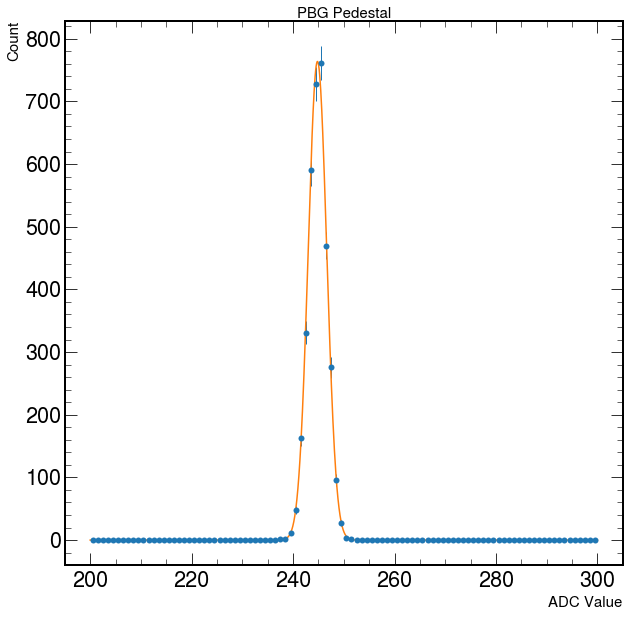

In [568]:
pbg_df = dataframes_dict['pbg_df']
adc_values = pbg_df['ch_34']
h, bins = np.histogram(adc_values, bins=100, range=(200, 300))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    
mask = (h > 0)
initial_params = [max(h),np.mean(adc_values), np.std(adc_values)]
m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']

x = np.linspace(200, 300, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, 'tab:orange')

plt.title('PBG Pedestal', fontsize = 15, pad=-15)  # Adjusted channel title
plt.xlabel('ADC Value', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

data_dict['pbg_df']['ch_34'] = data_dict['pbg_df']['ch_34'] - mu_fit
mask = data_dict['pbg_df']['ch_34'] <= sigma_cut*sigma_fit
data_dict['pbg_df']['ch_34'][mask] = 0

with open("PedestalMeans.txt", "a") as file:
    file.write('\n')
    file.write("Pbg")
    file.write('\n')
    file.write(str(mu_fit))
with open("PedestalSigmas.txt", "a") as file:
    file.write('\n')
    file.write("Pbg")
    file.write('\n')
    file.write(str(sigma_fit))

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


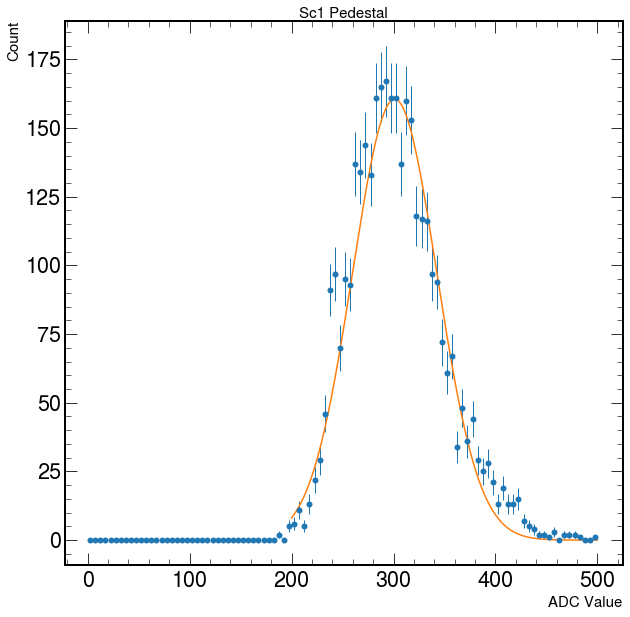

In [569]:
pbg_df = dataframes_dict['sc1_df']
adc_values = pbg_df['ch_32']
h, bins = np.histogram(adc_values, bins=100, range=(0, 500))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    
mask = (h > 0)
initial_params = [max(h),np.mean(adc_values), np.std(adc_values)]
m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']

x = np.linspace(200, 500, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, 'tab:orange')

plt.title('Sc1 Pedestal', fontsize = 15, pad=-15)  # Adjusted channel title
plt.xlabel('ADC Value', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

data_dict['sc1_df']['ch_32'] = data_dict['sc1_df']['ch_32'] - mu_fit
mask = data_dict['sc1_df']['ch_32'] <= sigma_cut*sigma_fit
data_dict['sc1_df']['ch_32'][mask] = 0

with open("PedestalMeans.txt", "a") as file:
    file.write('\n')
    file.write("Sc1")
    file.write('\n')
    file.write(str(mu_fit))
with open("PedestalSigmas.txt", "a") as file:
    file.write('\n')
    file.write("Sc1")
    file.write('\n')
    file.write(str(sigma_fit))

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


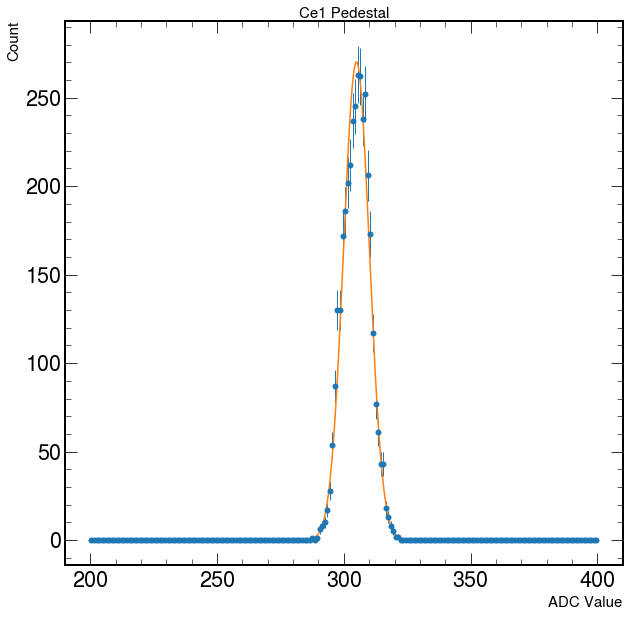

In [570]:
pbg_df = dataframes_dict['ce1_df']
adc_values = pbg_df['ch_35']
h, bins = np.histogram(adc_values, bins=200, range=(200, 400))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    
mask = (h > 0)
initial_params = [max(h),np.mean(adc_values), np.std(adc_values)]
m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']

x = np.linspace(200, 400, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, 'tab:orange')

plt.title('Ce1 Pedestal', fontsize = 15, pad=-15)  # Adjusted channel title
plt.xlabel('ADC Value', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

data_dict['ce1_df']['ch_35'] = data_dict['ce1_df']['ch_35'] - mu_fit
mask = data_dict['ce1_df']['ch_35'] <= sigma_cut*sigma_fit
data_dict['ce1_df']['ch_35'][mask] = 0

with open("PedestalMeans.txt", "a") as file:
    file.write('\n')
    file.write("Ce1")
    file.write('\n')
    file.write(str(mu_fit))
with open("PedestalSigmas.txt", "a") as file:
    file.write('\n')
    file.write("Ce1")
    file.write('\n')
    file.write(str(sigma_fit))

/Users/spreins/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


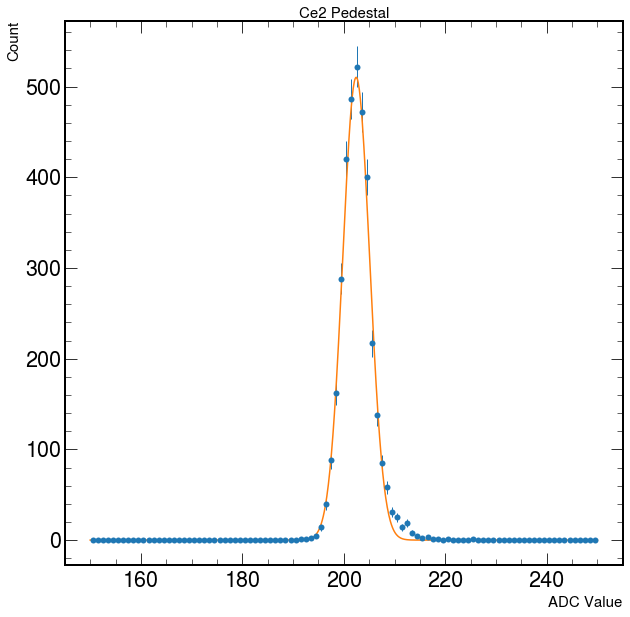

In [571]:
pbg_df = dataframes_dict['ce2_df']
adc_values = pbg_df['ch_37']
h, bins = np.histogram(adc_values, bins=100, range=(150, 250))
bin_centers = 0.5 * (bins[:-1] + bins[1:])
errors = np.sqrt(h)
plt.errorbar(bin_centers, h, yerr=errors, fmt='o', ecolor='tab:blue', color='tab:blue', capsize=0, elinewidth=1, markeredgewidth=0)
    
mask = (h > 0)
initial_params = [max(h),np.mean(adc_values), np.std(adc_values)]
m = Minuit(LeastSquares(bin_centers[mask], h[mask], errors[mask], gauss), A=initial_params[0], mu=initial_params[1], sigma=initial_params[2])
m.limits["sigma"] = (0, None)
m.migrad()
fitted_params = m.values
A_fit = fitted_params['A']
mu_fit = fitted_params['mu']
sigma_fit = fitted_params['sigma']

x = np.linspace(150, 250, 1000)
y_fit = gauss(x, A_fit, mu_fit, sigma_fit)
plt.plot(x, y_fit, 'tab:orange')

plt.title('Ce2 Pedestal', fontsize = 15, pad=-15)  # Adjusted channel title
plt.xlabel('ADC Value', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

data_dict['ce2_df']['ch_37'] = data_dict['ce2_df']['ch_37'] - mu_fit
mask = data_dict['ce2_df']['ch_37'] <= sigma_cut*sigma_fit
data_dict['ce2_df']['ch_37'][mask] = 0

with open("PedestalMeans.txt", "a") as file:
    file.write('\n')
    file.write("Ce2")
    file.write('\n')
    file.write(str(mu_fit))
with open("PedestalSigmas.txt", "a") as file:
    file.write('\n')
    file.write("Ce2")
    file.write('\n')
    file.write(str(sigma_fit))

In [572]:
with open(out_file_name, 'wb') as file:
    pickle.dump(data_dict, file)